In [10]:
%matplotlib inline
from utils.units import basis, u
from utils.units.sympy_helpers import split_unit_form as split_unit
from sympy.abc import s

rps = u.rad/u.s
gp = 2000*(u.rad/u.V)/(s*(s+4*rps)*(s+50*rps))*(rps**3)
gc = (s+7*rps)*0.05/rps
gs = u.V/u.rad
split_unit(gp*gc*gs)

(radian**2/second**2)*(2000*(0.35*radian/second + 0.05*s)/(s*(4*radian/second + s)*(50*radian/second + s)))

In [11]:
nu = basis(unitary=False)

In [12]:
import control.matlab as m
from utils.ctrlsys import step, s2tf
from utils.ratpolys import ratpoly_coeffs
from functools import partial

to_tf = s2tf$(?, s) .. nu.to_numeric$(as_expr=True)
u2symb = split_unit .. nu.to_symb

gp_tf = to_tf(gp)
gc_tf = to_tf(gc)
gs_tf = to_tf(gs)

gdirect_tf = gp_tf*gc_tf
gfeedback_tf = gs_tf
dt = 1.4*nu[u.s]/10
gcl_tf = m.feedback(gdirect_tf, gfeedback_tf)
gcl_dtf = m.feedback(m.c2d(gdirect_tf, dt), gfeedback_tf)
gcl_tf.dcgain() |> u2symb$(u.rad/u.V)

1.0*(radian/volt)

In [13]:
import matplotlib.pyplot as plt
from itertools import cycle
from utils.mpl import loc_to_anchor, nu_axes, nu_axis
from utils.ctrlsys import zoh_stairs

def io_axes(subplots=plt.subplots, rcparams=plt.rcParams):
    fig, ax_x = subplots()
    ax_y = ax_x.twinx()
    color_iter = iter(cycle(rcparams['axes.prop_cycle'].by_key()["color"]))
    next_color = lambda: next(color_iter)

    def post(gain: float, legend_loc: str):
        ax_x.set_ylim(coord/gain for coord in ax_y.get_ylim())
        fig.legend(
            bbox_to_anchor=loc_to_anchor(legend_loc),
            loc=legend_loc,
            bbox_transform=ax_x.transAxes)
    
    return fig, (ax_x, ax_y), next_color, post

def nu_twinx_axes(nu, ax1, ax2, xunit, y1unit, y2unit):
    set_xlabel, set_y1label = nu_axes(
        ax1, nu, xunit, y1unit
    )
    set_y2label = nu_axis(
        ax2.yaxis, nu, y2unit, is_x=False
    )
    return set_xlabel, set_y1label, set_y2label

def nu_sharex_axes(nu, ax1, ax2, xunit, y1unit, y2unit,
                   x_in_db=False, y1_in_db=False, y2_in_db=False):
    my_nu_ax = nu_axes$(?, nu, xunit, ?, x_in_db=x_in_db)
    set_xlabel, set_y1label = my_nu_ax(
        ax1, y1unit, y_in_db=y1_in_db)
    _, set_y2label = my_nu_ax(ax2, y2unit, y_in_db=y2_in_db)
    return set_xlabel, set_y1label, set_y2label


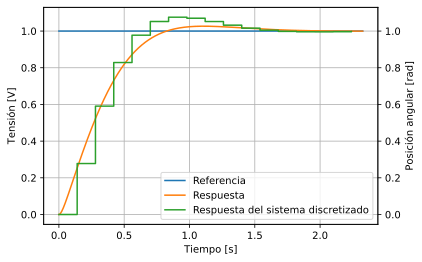

In [14]:
import numpy as np

fig, (ax_e, ax_r), next_color, set_gain_and_legend_loc = io_axes()

t, (ref, resp) = step(reversed .. m.step$(gcl_tf), ampl=nu[u.V])
td = np.arange(min(t), max(t), gcl_dtf.dt)

_, (_, dresp) = step(reversed .. m.step$(gcl_dtf), ampl=nu[u.V], t=td)

set_time_title, set_e_title, set_r_title = nu_twinx_axes(
    nu, ax_e, ax_r, u.s, u.V, u.rad
)
ax_e.plot(t, ref, color=next_color(), label="Referencia")
ax_r.plot(t, resp, color=next_color(), label="Respuesta")
ax_r.plot(*zoh_stairs(td, dresp), color=next_color(), label="Respuesta del sistema discretizado")

set_time_title("Tiempo")
set_e_title("Tensión")
set_r_title("Posición angular")
ax_e.grid()
set_gain_and_legend_loc(gcl_tf.dcgain(), "lower right")


In [15]:
from utils.ctrl import bode_plot
import matplotlib.ticker

def control_bode_axes():
    fig, (ax_gain, ax_phase) = plt.subplots(2, sharex=True)
    ax_gain.set_xscale('log')

    def add_deg_locator(phase_tick=45):
        loc = matplotlib.ticker.MultipleLocator(base=phase_tick)
        loc_minor = matplotlib.ticker.MultipleLocator(base=phase_tick/3)
        ax_phase.yaxis.set_major_locator(loc)
        ax_phase.yaxis.set_minor_locator(loc_minor)
    
    return ( 
        fig, (ax_gain, ax_phase),
        bode_plot$(?, ax_gain, ax_phase, grid=False),
        add_deg_locator
    )

/home/fakui/.local/lib/python3.9/site-packages/control/lti.py:199: UserWarning: __call__: evaluation above Nyquist frequency
  warn("__call__: evaluation above Nyquist frequency")


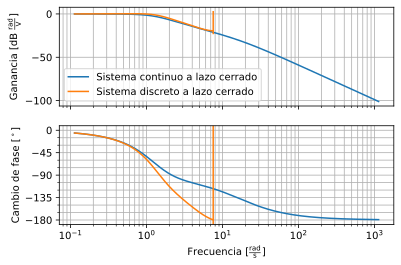

In [16]:
from math import pi
from utils.mpl import set_datalim

fig, (ax_gain, ax_phase), add_bode, add_deg_locator = control_bode_axes()

add_bode = add_bode$(deg=False, dB=True)

add_bode(gcl_tf, label="Sistema continuo a lazo cerrado")
add_bode(gcl_dtf, label="Sistema discreto a lazo cerrado")

add_deg_locator()

set_freq_label, set_phase_label, set_gain_label = nu_sharex_axes(
    nu, ax_phase, ax_gain, u.rad/u.s, u.deg, u.rad/u.V, y2_in_db=True)

set_freq_label("Frecuencia")
set_gain_label("Ganancia")
set_phase_label("Cambio de fase")
ax_gain.grid(which='both')
ax_phase.grid(which='both')
set_datalim(ax_phase, y=(-nu[180*u.deg], 0))

ax_gain.legend(); None


In [17]:
%matplotlib tk
import control
from utils.ctrl import sys_deu
from utils.mpl import rcparam
with rcparam({"figure.dpi": 120}):
    control.sisotool(sys_deu(m.c2d(gp_tf, dt), nu, u.V, u.rad))


/home/fakui/.local/lib/python3.9/site-packages/control/sisotool.py:84: MatplotlibDeprecationWarning: 
The get_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.get_window_title or GUI-specific methods instead.
  if fig.canvas.get_window_title() != 'Sisotool':
/home/fakui/.local/lib/python3.9/site-packages/control/sisotool.py:87: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title('Sisotool')
/home/fakui/.local/lib/python3.9/site-packages/control/rlocus.py:180: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "m." (-> marker='.'). The keyword argument will take precedence.
  fig.axes[1].plot(


Clicked at    0.02202   +0.5181j gain      5.596 damp     0.3948


/home/fakui/.local/lib/python3.9/site-packages/control/rlocus.py:628: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "m." (-> marker='.'). The keyword argument will take precedence.
  ax_rlocus.plot(


Clicked at    -0.2071   +0.6682j gain      11.21 damp     0.1876


/home/fakui/.local/lib/python3.9/site-packages/control/rlocus.py:628: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "m." (-> marker='.'). The keyword argument will take precedence.
  ax_rlocus.plot(


Clicked at     0.2913 +0.002081j gain    0.06961 damp          1


/home/fakui/.local/lib/python3.9/site-packages/control/rlocus.py:628: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "m." (-> marker='.'). The keyword argument will take precedence.
  ax_rlocus.plot(
/home/fakui/.local/lib/python3.9/site-packages/control/freqplot.py:377: UserWarning: stability_margins: Falling back to 'frd' method because of chance of numerical inaccuracy in 'poly' method.
  margin = stability_margins(sys, method=method)


Clicked at      0.239   +0.2085j gain     0.7942 damp     0.8481


/home/fakui/.local/lib/python3.9/site-packages/control/rlocus.py:628: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "m." (-> marker='.'). The keyword argument will take precedence.
  ax_rlocus.plot(


Clicked at     0.1265   +0.4102j gain      3.198 damp     0.5537


/home/fakui/.local/lib/python3.9/site-packages/control/rlocus.py:628: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "m." (-> marker='.'). The keyword argument will take precedence.
  ax_rlocus.plot(
